<a href="https://colab.research.google.com/github/meshwa-23/Codeforces-Questions/blob/main/medical_insurance_cost_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# upload
from google.colab import files
uploaded = files.upload()   # choose archive.zip
# or mount drive
from google.colab import drive
drive.mount('/content/drive')


Saving archive.zip to archive (1).zip
Mounted at /content/drive


# **Quick EDA & data cleaning**

In [ ]:
import pandas as pd
import zipfile

# 1. Extract your archive
with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("data")   # creates /content/data

# 2. Check extracted files
import os
print(os.listdir("data"))

# 3. Load the CSV (adjust name if needed)
df = pd.read_csv("data/insurance.csv")

# 4. Basic exploration
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.head())


['insurance.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000

In [24]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor


# **Separate features & target**

In [ ]:
X = df.drop("charges", axis=1)
y = df["charges"]


# Identify numeric & categorical columns

In [ ]:
num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]


# Check distributions

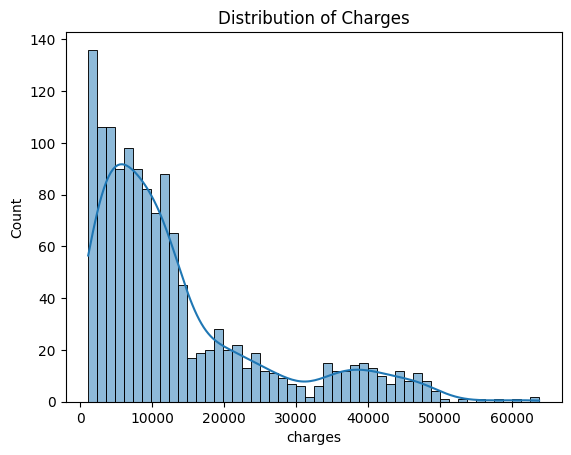

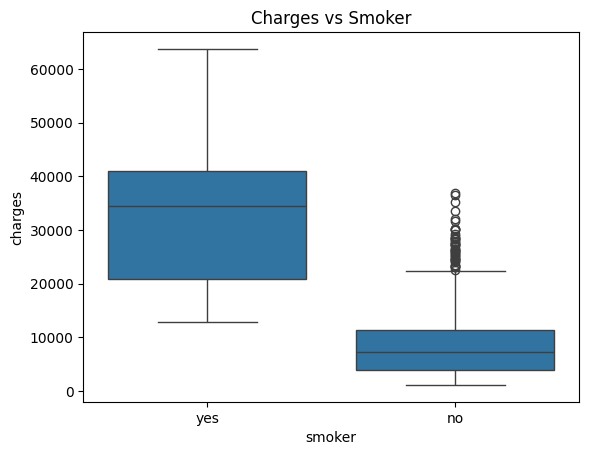

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df["charges"], bins=50, kde=True)
plt.title("Distribution of Charges")
plt.show()

sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Charges vs Smoker")
plt.show()


# Transform skewed target

In [ ]:
import numpy as np
y = np.log1p(y)   # log(1+charges)


# Prepare data for modeling

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


# Build Baseline Models

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Build pipelines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Linear Regression pipeline
linreg_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Random Forest pipeline
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])


# Train models


In [ ]:
linreg_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', RandomForestRegressor(random_state=42))])

# Evaluate models

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

linreg_results = evaluate_model(linreg_pipe, X_test, y_test)
rf_results = evaluate_model(rf_pipe, X_test, y_test)

print("Linear Regression:", linreg_results)
print("Random Forest:", rf_results)


Linear Regression: {'MAE': 0.26965057295320444, 'RMSE': np.float64(0.41893807245607023), 'R2': 0.804741079139302}
Random Forest: {'MAE': 0.18744735154099304, 'RMSE': np.float64(0.3715122817514462), 'R2': 0.8464472581709949}


In [ ]:
from sklearn.model_selection import cross_val_score, KFold


In [ ]:
# 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
import numpy as np

# Linear Regression CV
linreg_scores = cross_val_score(linreg_pipe, X, y, cv=cv,
                                scoring="neg_mean_squared_error")
linreg_rmse = np.sqrt(-linreg_scores)

# Random Forest CV
rf_scores = cross_val_score(rf_pipe, X, y, cv=cv,
                            scoring="neg_mean_squared_error")
rf_rmse = np.sqrt(-rf_scores)

print("Linear Regression CV RMSE:", linreg_rmse)
print("Linear Regression Mean RMSE:", linreg_rmse.mean())

print("Random Forest CV RMSE:", rf_rmse)
print("Random Forest Mean RMSE:", rf_rmse.mean())


Linear Regression CV RMSE: [0.41893807 0.46362522 0.413357   0.47228464 0.45537804]
Linear Regression Mean RMSE: 0.44471659630002414
Random Forest CV RMSE: [0.3747526  0.40237901 0.38277897 0.38337841 0.41625731]
Random Forest Mean RMSE: 0.39190926017616073


**Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


# **Define parameter grid for Random Forest**

In [ ]:
param_dist = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["auto", "sqrt", "log2"]
}


# **Run RandomizedSearchCV**

In [ ]:
random_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=20,          # number of random combinations to try
    cv=5,               # 5-fold cross validation
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'region'])])),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 5, 10, 20],
                                        'model__max_features': ['auto', 'sqrt',
                                                                'log2'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [100, 200, 300,
                                                                500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

# **Check best parameters & performance**

In [ ]:
print("Best Parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Tuned Random Forest - MAE:", mae)
print("Tuned Random Forest - RMSE:", rmse)
print("Tuned Random Forest - R2:", r2)


Best Parameters: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 20}
Tuned Random Forest - MAE: 0.21069363148225373
Tuned Random Forest - RMSE: 0.37380673960593763
Tuned Random Forest - R2: 0.844544719406868


# Save the tuned model for late

In [ ]:
import joblib
joblib.dump(best_rf, "best_model_pipeline.joblib")


['best_model_pipeline.joblib']

# Save the tuned model

In [22]:
import joblib

# save the tuned random forest pipeline
joblib.dump(best_rf, "best_model_pipeline.joblib")
print("Model saved as best_model_pipeline.joblib")


Model saved as best_model_pipeline.joblib


# Load the model

In [23]:
import joblib
import pandas as pd

# load the trained model
model = joblib.load("best_model_pipeline.joblib")

# example prediction
example = pd.DataFrame([{
    "age": 30,
    "sex": "male",
    "bmi": 28.5,
    "children": 2,
    "smoker": "no",
    "region": "southeast"
}])

prediction = model.predict(example)[0]
print("Predicted charges:", prediction)


Predicted charges: 8.504078709276154


In [27]:
import joblib

# save your trained model pipeline
joblib.dump(model, "best_model_pipeline.joblib")
print("Model re-saved successfully!")


Model re-saved successfully!


In [28]:
from google.colab import files
files.download("best_model_pipeline.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>